In [1]:
import wfdb
from wfdb import processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import scipy
from scipy.fft import fft, ifft
PATH = "apnea-ecg-database-1.0.0/"

SAMPFROM = 0
SAMPTO = 5000

In [2]:
record_ecg = wfdb.rdrecord(PATH + "a01", sampfrom=SAMPFROM, sampto=SAMPTO)
annotation = wfdb.rdann(PATH+ "a01", 'qrs', sampfrom=SAMPFROM, sampto=SAMPTO, shift_samps=True)

df2 = record_ecg.to_dataframe()
df2['time'] = df2.index.microseconds / 1000 + df2.index.seconds * 1000
df2 = df2[['time', 'ECG']]
df2.reset_index(drop=True, inplace=True)
df2.head()

,time,ECG
0,0.0,-0.060
1,10.0,-0.065
2,20.0,-0.060
3,30.0,-0.075
4,40.0,-0.065


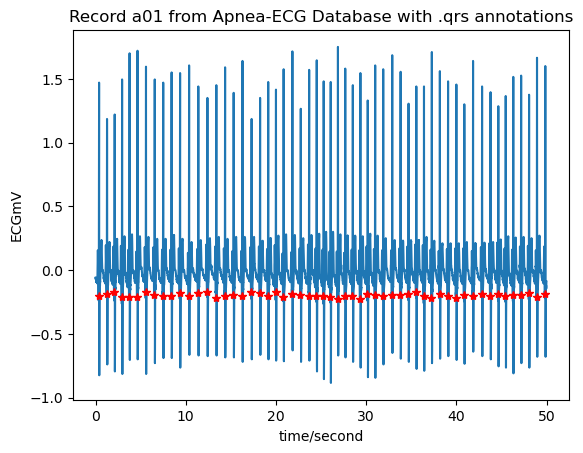

In [3]:
wfdb.plot_wfdb(record=record_ecg, annotation=annotation,
               title='Record a01 from Apnea-ECG Database with .qrs annotations',
               time_units='seconds')

[  34  123  207  290  373  461  554  652  746  839  932 1033 1135 1236
 1335 1432 1527 1625 1725 1820 1910 1995 2081 2178 2271 2364 2447 2525
 2602 2683 2764 2848 2932 3013 3095 3185 3285 3378 3466 3552 3637 3724
 3813 3904 3996 4084 4181 4281 4375 4461 4543 4626 4714 4802 4890 4982]
[ 89.  84.  83.  83.  88.  93.  98.  94.  93.  93. 101. 102. 101.  99.
  97.  95.  98. 100.  95.  90.  85.  86.  97.  93.  93.  83.  78.  77.
  81.  81.  84.  84.  81.  82.  90. 100.  93.  88.  86.  85.  87.  89.
  91.  92.  88.  97. 100.  94.  86.  82.  83.  88.  88.  88.  92.]


Text(0.5, 1.0, 'Fragment zapisu EKG dla jednego uderzenia')

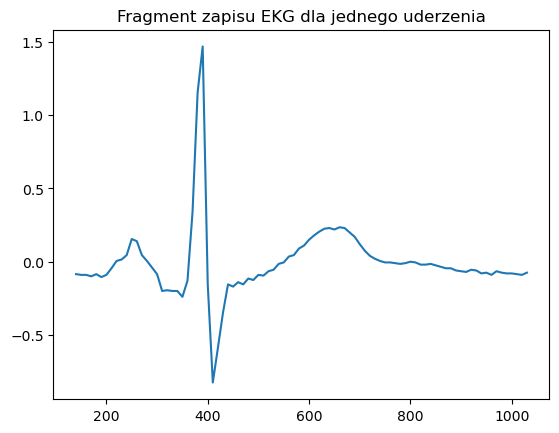

In [4]:
#przetwarzanie danych timeeeeeeee
print(annotation.sample)
num_of_beats = annotation.sample.size - 1
offset_l = 20
offset_r = 70

temp = np.zeros(num_of_beats)

for beat in range(num_of_beats):
    temp[beat] = annotation.sample[beat+1] - annotation.sample[beat]
print(temp)

#test czy to pojedyncze bicie

plt.plot(df2['time'][34 - offset_l:34+offset_r], df2['ECG'][34 - offset_l:34 + offset_r])
plt.title('Fragment zapisu EKG dla jednego uderzenia')

In [5]:
beats = np.zeros((num_of_beats, offset_l+offset_r))

for beat in range(num_of_beats):
    start_pos = annotation.sample[beat]
    beats[beat] = df2['ECG'][start_pos-offset_l:start_pos+offset_r]



In [6]:
#jakas zabawa
# qrs_inds = processing.qrs.gqrs_detect(sig=record_ecg.p_signal[:,0], fs=200)
# qrs_inds = (1 / record_ecg.fs) * qrs_inds
# # print(qrs_inds.size)
# # Utwórz nowy wykres i oś
# signal = record_ecg.p_signal[:, 0]
# time = (1 / record_ecg.fs) * np.arange(len(signal))

# # Utwórz nowy wykres
# fig, ax = plt.subplots()

# # Wyświetl sygnał EKG na wykresie
# ax.plot(time, signal)

# # Wygeneruj i wyrysuj dodatkowe punkty na tym samym wykresie
# ax.plot(qrs_inds, np.zeros(qrs_inds.size), 'ro')  # 'ro' oznacza czerwone kropki

# # Wyświetl wykres z dodatkowymi punktami i etykietami
# plt.show()

In [7]:
scaler = StandardScaler()
scaler.fit(beats)
X_scaled = scaler.transform(beats)

In [8]:
pca = decomposition.PCA(n_components=4)
X_transformed = pca.fit_transform(X_scaled)

In [9]:
eigen_vectors = pca.components_
eigen_values = pca.explained_variance_
# print(eigen_vectors)
print(eigen_values)

[33.10656736 17.33770891  9.19548653  6.47632685]


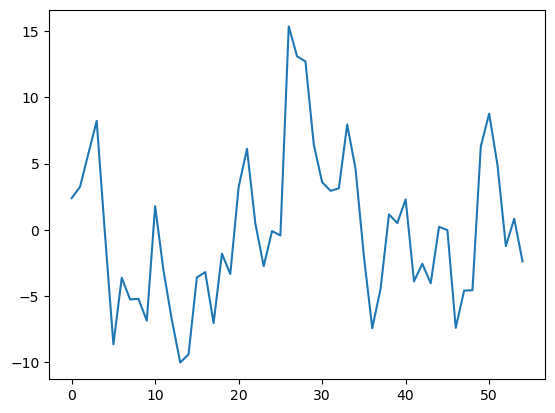

In [10]:
# plt.plot(df2.ECG)
plt.plot(X_transformed[:,0])
# plt.plot(X_transformed[:,1])
# plt.plot(X_transformed[:,2])
# plt.plot(X_transformed[:,3])
# plt.xlim(0, 100)

In [11]:
X_transformed

array([[ 2.39055732e+00,  5.82530217e+00, -9.13758219e-03,
        -1.18533277e+00],
       [ 3.23554115e+00,  2.41151955e+00,  5.80591109e+00,
        -1.89236496e+00],
       [ 5.73547317e+00,  2.58817446e+00,  2.32858368e+00,
        -4.01173178e+00],
       [ 8.21502777e+00, -6.24532647e+00,  2.06651367e+00,
        -2.36239710e+00],
       [-3.89725897e-01, -6.28868985e+00, -3.37250556e+00,
        -1.00966674e+00],
       [-8.63610498e+00, -3.30154575e+00, -5.17624905e+00,
        -1.02619960e+00],
       [-3.61246630e+00,  8.03638755e+00, -2.79806654e+00,
        -4.71515932e+00],
       [-5.24858318e+00, -4.84275034e+00,  2.86679021e+00,
        -2.22449421e+00],
       [-5.20371119e+00, -5.02754605e+00, -5.15719093e-02,
        -3.38820817e+00],
       [-6.85176625e+00, -5.94540778e+00, -7.82638776e-01,
        -6.12609769e+00],
       [ 1.78063653e+00,  8.01716278e+00, -2.48123403e+00,
         1.80139479e+00],
       [-3.06365755e+00, -7.05633808e-01, -2.67943014e+00,
      

In [12]:
record = wfdb.rdrecord(PATH + "a01r", sampfrom=SAMPFROM, sampto=SAMPTO)

df = record.to_dataframe()
df['time'] = df.index.microseconds / 1000 + df.index.seconds * 1000
df = df[['time', 'Resp C', 'Resp A', 'Resp N']]
df.reset_index(drop=True, inplace=True)
df.head()

,time,Resp C,Resp A,Resp N
0,0.0,-0.1015,-0.3446,0.23545
1,10.0,-0.1025,-0.3455,0.23640
2,20.0,-0.1035,-0.3464,0.23735
3,30.0,-0.1045,-0.3473,0.23830
4,40.0,-0.1055,-0.3482,0.23925


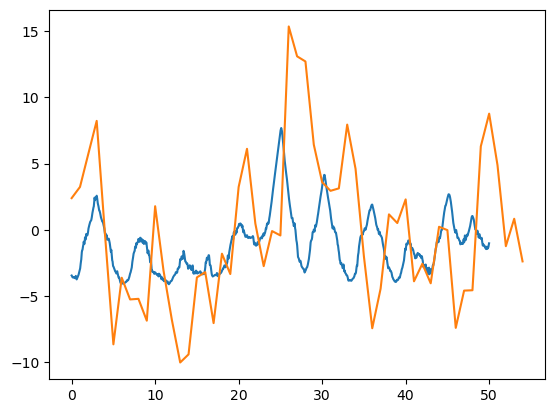

In [13]:
#plt.plot(df2['time'], df2['ECG'])
# plt.plot(df['time'], df['Resp C'])
plt.plot(df['time']/1000, df['Resp A']*10)
# plt.plot(df['time'], df['Resp N'])


plt.plot(X_transformed[:,0])

In [14]:
y_resp_norm = (df['Resp A']-min(df['Resp A'])) / max(df['Resp A']-min(df['Resp A']))
y_PCA_norm = (X_transformed[:,0]-min(X_transformed[:,0])) / max(X_transformed[:,0]-min(X_transformed[:,0]))
coeff = y_resp_norm.size/100 / y_PCA_norm.size

Text(0.5, 1.0, 'PCA nieprzeskalowane')

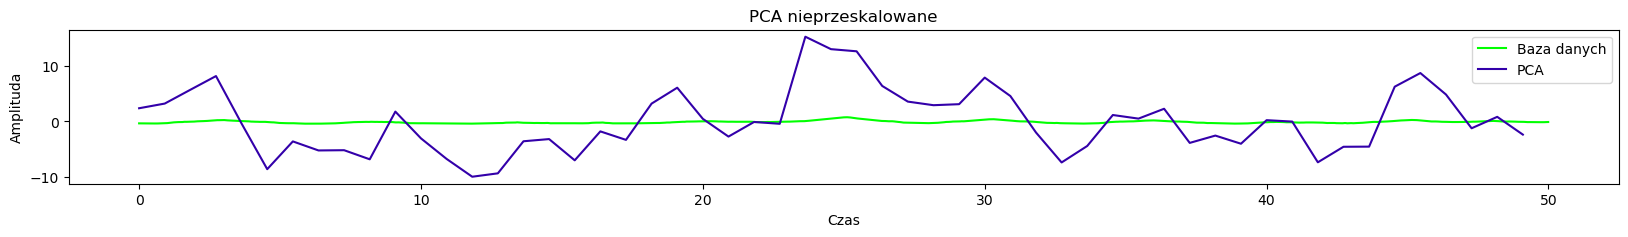

In [15]:
plt.figure(figsize=(20, 2))
plt.plot(df['time']/1000, df['Resp A'], label='Baza danych', color='lime')
plt.plot(np.arange(X_transformed[:,0].size)*coeff, X_transformed[:,0], label='PCA', color=('#3300AA'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title('PCA nieprzeskalowane')

<Figure size 2000x200 with 0 Axes>

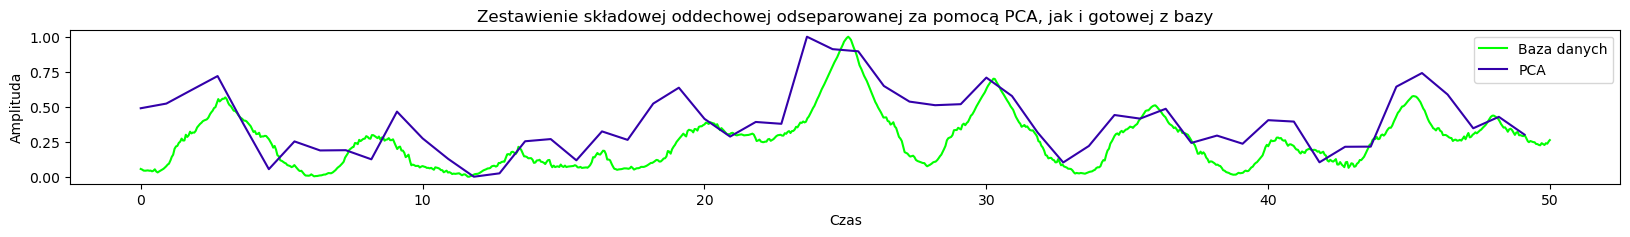

<Figure size 2000x200 with 0 Axes>

In [16]:
plt.figure(figsize=(20, 2))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.plot(np.arange(X_transformed[:,0].size)*coeff, y_PCA_norm, label='PCA', color=('#3300AA'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title('Zestawienie składowej oddechowej odseparowanej za pomocą PCA, jak i gotowej z bazy')
# print(scipy.signal.coherence(y_resp_norm, y_PCA_norm))
plt.figure(figsize=(20, 2))
# plt.cohere(y_resp_norm, y_PCA_norm)

In [17]:
kpca = decomposition.KernelPCA(n_components=4, kernel='cosine')
X_ktransformed = kpca.fit_transform(X_scaled)

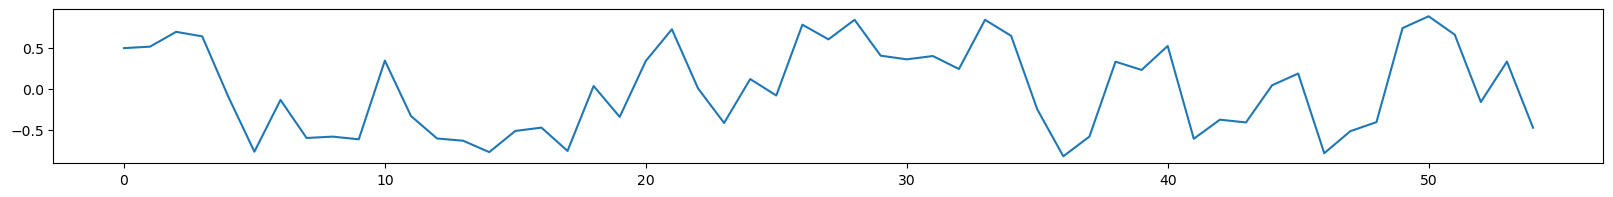

In [18]:
plt.figure(figsize=(20, 2))
plt.plot(X_ktransformed[:,0])

In [19]:
y_kPCA_norm = (X_ktransformed[:,0]-min(X_ktransformed[:,0])) / max(X_ktransformed[:,0]-min(X_ktransformed[:,0]))

<Figure size 2000x200 with 0 Axes>

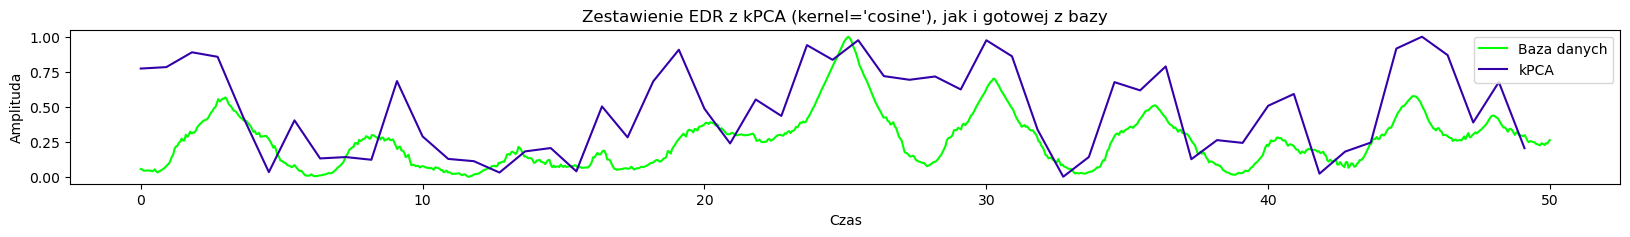

<Figure size 2000x200 with 0 Axes>

In [20]:
plt.figure(figsize=(20, 2))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.plot(np.arange(X_ktransformed[:,0].size)*coeff, y_kPCA_norm, label='kPCA', color=('#3300AA'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title(f"Zestawienie EDR z kPCA (kernel=\'{kpca.kernel}\'), jak i gotowej z bazy")
plt.figure(figsize=(20, 2))
# plt.cohere(y_resp_norm, y_kPCA_norm)

In [21]:
ica = decomposition.FastICA(n_components=4)
X_ica_transformed = ica.fit_transform(X_scaled)
ica_chosen = X_ica_transformed[:,2]

c:\Users\marta\anaconda3\envs\sem8\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


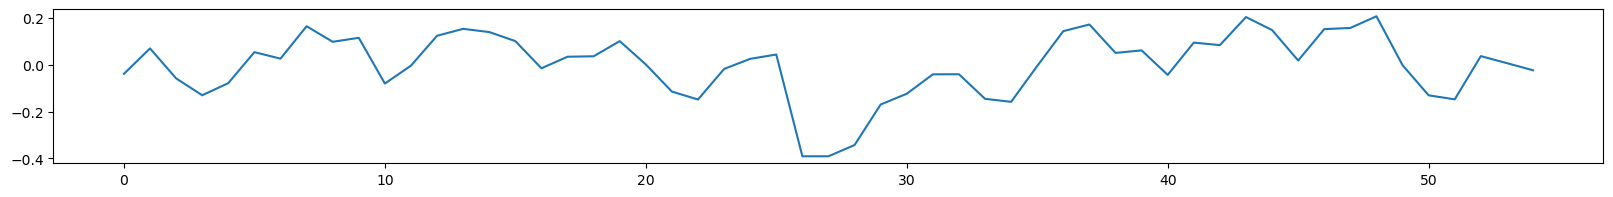

In [22]:
plt.figure(figsize=(20, 2))
plt.plot(ica_chosen)

In [23]:
y_ICA_norm = (ica_chosen-min(ica_chosen)) / max(ica_chosen-min(ica_chosen))

<Figure size 2000x200 with 0 Axes>

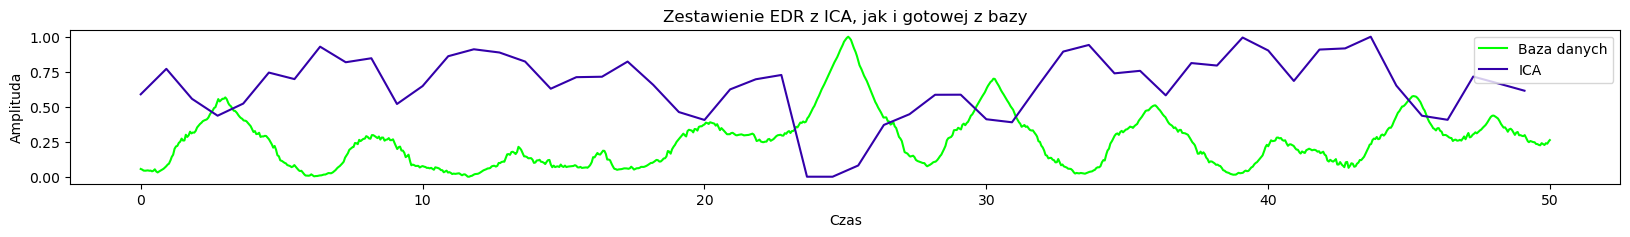

<Figure size 2000x200 with 0 Axes>

In [24]:
plt.figure(figsize=(20, 2))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.plot(np.arange(ica_chosen.size)*coeff, y_ICA_norm, label='ICA', color=('#3300AA'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title(f"Zestawienie EDR z ICA, jak i gotowej z bazy")
plt.figure(figsize=(20, 2))
# plt.cohere(y_resp_norm, y_ICA_norm)

Text(0.5, 1.0, 'Zestawienie EDR wykonanymi różnymi metodami, jak i gotowej z bazy')

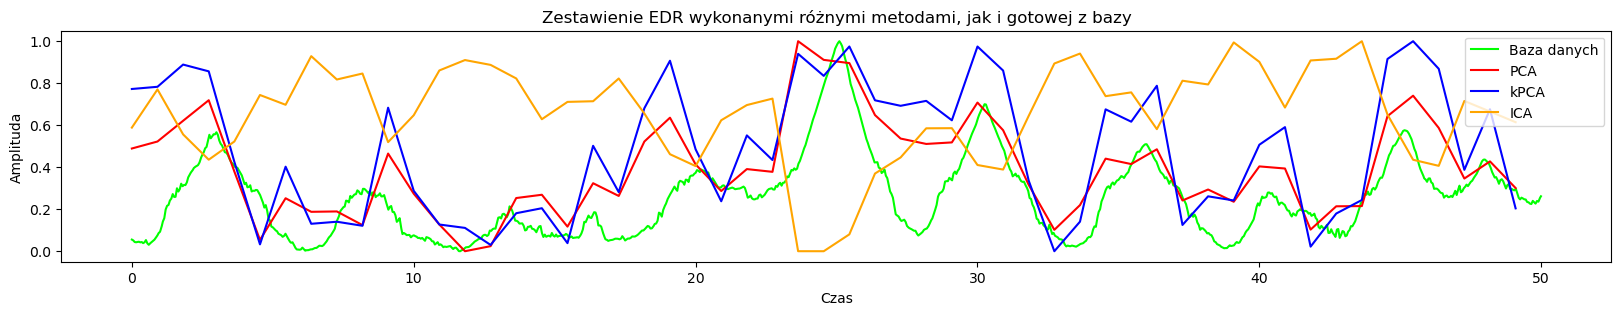

In [25]:
plt.figure(figsize=(20, 3))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.plot(np.arange(X_transformed[:,0].size)*coeff, y_PCA_norm, label='PCA', color=('red'))
plt.plot(np.arange(X_ktransformed[:,0].size)*coeff, y_kPCA_norm, label='kPCA', color=('blue'))
plt.plot(np.arange(ica_chosen.size)*coeff, y_ICA_norm, label='ICA', color=('orange'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title(f"Zestawienie EDR wykonanymi różnymi metodami, jak i gotowej z bazy")

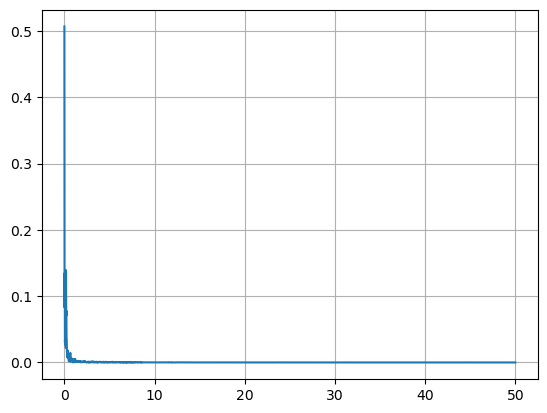

In [26]:
from scipy.fftpack import fftfreq
N = SAMPTO-SAMPFROM
# sample spacing
T = 1.0 / 100.0

yf = fft(np.array(y_resp_norm))
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

c:\Users\marta\anaconda3\envs\sem8\lib\site-packages\numpy\ma\core.py:3375: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
c:\Users\marta\anaconda3\envs\sem8\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 10.0)

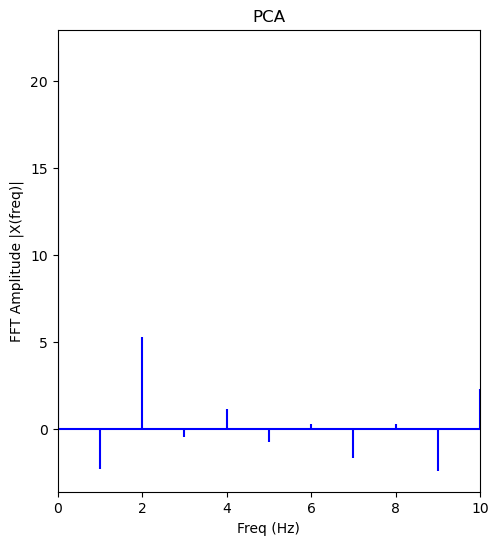

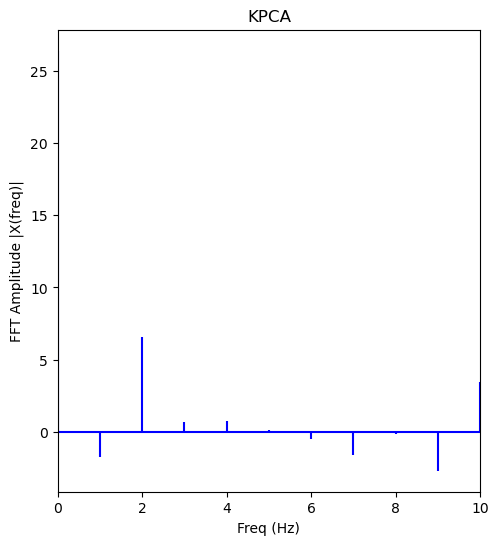

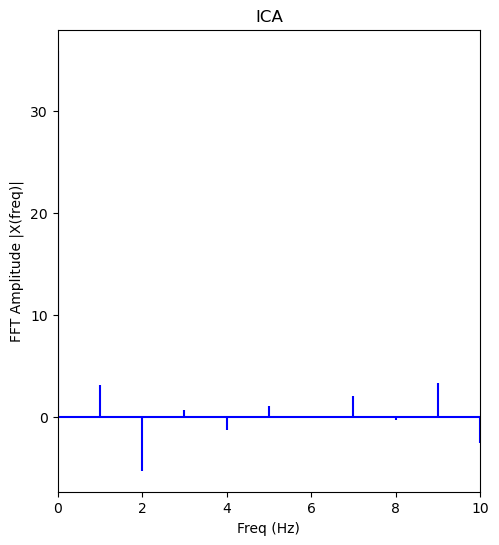

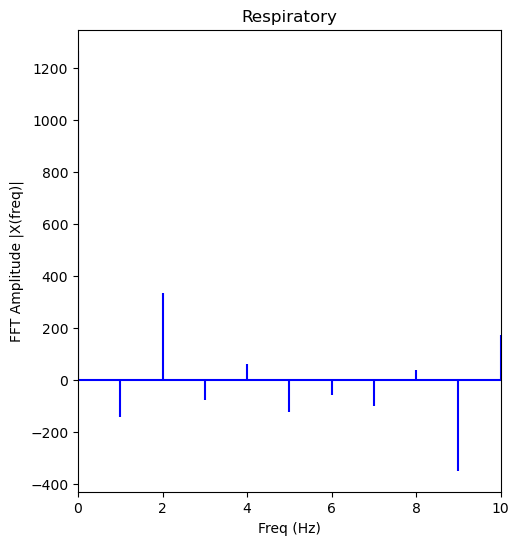

In [39]:
from scipy.fftpack import fft, ifft

sr1 = 55
sr2 = 5000
ts1 = 1.0/sr1
ts2 = 1.0/sr2
t1 = np.arange(0,1,ts1)
t2 = np.arange(0,1,ts2)

x_pca = np.array(y_PCA_norm) #ica: sr = 55, norm: 5000,  kpca: 55, pca: 55
x_kpca = np.array(y_kPCA_norm) 
x_ica = np.array(y_ICA_norm) 
x_resp = np.array(y_resp_norm) 

X_pca = fft(x_pca)
N_pca = len(X_pca)
n_pca = np.arange(N_pca)

X_kpca = fft(x_kpca)
N_kpca = len(X_kpca)
n_kpca = np.arange(N_kpca)

X_ica = fft(x_ica)
N_ica = len(X_ica)
n_ica = np.arange(N_ica)

X_resp = fft(x_resp)
N_resp = len(X_resp)
n_resp = np.arange(N_resp)

T1 = N_pca/sr1
T2 = N_kpca/sr1
T3 = N_ica/sr1
T4 = N_resp/sr2
freq1 = n_pca/T1
freq2 = n_kpca/T1
freq3 = n_ica/T1
freq4 = n_resp/T2

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.title("PCA")
plt.stem(freq1, X_pca, 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.title("KPCA")
plt.stem(freq2, X_kpca, 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.title("ICA")
plt.stem(freq3, X_ica, 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.title("Respiratory")
plt.stem(freq4, X_resp, 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

# plt.subplot(122)
# plt.plot(t, ifft(X), 'r')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.tight_layout()
# plt.show()